# Recommender System

This notebook will detail all of the steps invovled in creating this music recommender system. This code is based on the google colab notebook and educational code available at: 

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=StMo4lDmLqpc 


#### The notebook is split into 4 sections:

1) Building rating matrix/ Calculating error

2) Training the matrix factorisation model

3) Inspecting embeddings

4) Regularisation in matrix factorisation


## Import required dependencies

In [107]:
from __future__ import print_function
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

## 1) Preliminaries

In [108]:
artists = pd.read_csv('Data/artists.dat', sep='	')
tags = pd.read_csv('Data/tags.dat', sep='	', encoding='latin-1')
user_artists = pd.read_csv('Data/user_artists.dat', sep='	')
user_friends = pd.read_csv('Data/user_friends.dat', sep='	')
user_tagged_artists_tstamp = pd.read_csv('Data/user_taggedartists-timestamps.dat', sep='	')
user_tagged_artists = pd.read_csv('Data/user_taggedartists.dat', sep='	')

We create a function to be used later for splitting the data in testing and training sets

In [109]:
# Split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

### Building matrix

We design a function that maps the ```user_artists``` data to a tensorflow sparsetensor representation. Most users will not have rated each artist so this is full of 0's and hence becomes a very large matrix. This function allows us to efficiently capture this data

In [110]:
def build_rating_sparse_tensor(user_artists_df):
    indices = user_artists_df[['userID', 'artistID']].values
    values = user_artists_df['weight'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[len(user_artists['userID'].unique()), len(artists['id'].unique())])

### Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only. It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

The function below is created to calculate this

In [111]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

## 2) Training the Matrix Factorization model

### Collaborative Filtering Model (CF Model)
This class trains a matrix factorization model. Stochastic gradient descent is used in the function as the optimiser.


In [112]:
class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
              tf.variables_initializer(opt.variables()),
              tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

### Build the model

We build the model that uses the `sparse_mean_square_error` function. We write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [113]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
    embeddings = {
      "userID": U,
      "artistID": V
  }
    return CFModel(embeddings, train_loss, [metrics])

In [114]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


 We convert our columns into the appropriate data type before running it through the model

In [115]:
user_artists['userID'] = user_artists['userID'].astype(str)
user_artists['artistID'] = user_artists['artistID'].astype(str)
user_artists['weight'] = user_artists['weight'].astype(float)
user_artists = user_artists.sample(frac=1).reset_index(drop=True)

### Changing user id

We get errors when using the user data as is, as the user ID values and artist ID values are not in sequential order and are often higher than the index value so we will change them so they run from 0-1891, and 0-17631 respectively.

In [116]:
user_artists.userID.unique().astype(int).max()

2100

In [117]:
user_artists.artistID.unique().astype(int).max()

18745

In [118]:
#Extract userID column
userids = np.asarray(user_artists.userID)

#Remap the column
u_mapper, u_ind = np.unique(userids, return_inverse=True)

In [119]:
#Extract artistID column
artistids = np.asarray(user_artists.artistID)

#Remap the column
a_mapper, a_ind = np.unique(artistids, return_inverse=True)

In [120]:
#Assert that u_ind and userID column are of same size
assert(len(u_ind) == len(user_artists.userID))

#Assert that a_ind and artistID column are of same size
assert(len(a_ind) == len(user_artists.artistID))

In [121]:
# Let's replace old columns with new ind ones
user_artists.userID = u_ind
user_artists.artistID = a_ind

#Let's ensure the max value is approriate
assert(user_artists.userID.unique().max() == 1891)
assert(user_artists.artistID.unique().max() == 17631)

In [122]:
user_artists.describe()

,userID,artistID,weight
count,92834.000000,92834.000000,92834.00000
mean,947.051339,9978.722494,745.24393
std,546.351377,4420.048446,3751.32208
min,0.000000,0.000000,1.00000
25%,473.000000,7789.250000,107.00000
50%,950.000000,10305.000000,260.00000
75%,1419.000000,13017.000000,614.00000
max,1891.000000,17631.000000,352698.00000


### Normalisation

The variety in weights are very large which will cause issues with our ```CFModel``` so we normalise these values between a value of 0-1 

The code below can be uncommented to try a z score normalisation for different results

In [123]:
# copy the data
user_artists_norm = user_artists.copy()
  
# apply normalization techniques by Column weight
column = 'weight'
user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].min()) / (user_artists_norm[column].max() - user_artists_norm[column].min())    

# z score normalisation
#user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].mean()) / user_artists_norm[column].std()    
  
# view normalized data
user_artists_norm.head()

,userID,artistID,weight
0,1563,9976,0.004494
1,773,14463,0.002540
2,1458,138,0.000102
3,1552,13817,0.002087
4,1199,12104,0.002793


### Build the CF Model and train it

 iteration 1000: train_error=0.018905, test_error=0.453727

[{'train_error': 0.018905161, 'test_error': 0.45372707}]

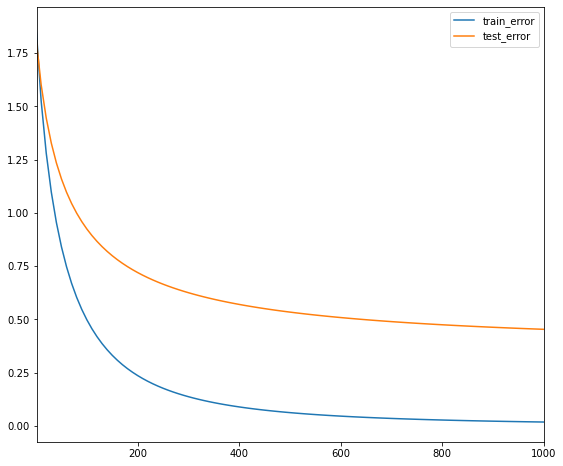

In [124]:
model = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

## 3) Inspecting the Embeddings

We look at the recommendations of the system using the dot product and cosine similarity which are two different similarity measures. We create a nearest neighbours function to recommend similar artists.

In [125]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):

    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [126]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  artists[artists['name'].str.contains(title_substring)].index.values
  titles = artists.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artists with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artistID"][artistID], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'names': artists['name']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Testing

We input an artist to see what recommendations our system returns to us

In [127]:
artist_neighbors(model, "Johnny Cash", DOT)
artist_neighbors(model, "Johnny Cash", COSINE)

Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
712,6.415318,Johnny Cash
6564,4.828962,Cassiane
10318,4.443741,Taio Cruz Feat. Kylie Minogue
2139,4.302609,Jane Air
4638,4.285572,SEGA
3599,4.277805,Jaromír Nohavica


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
1764,0.593273,Yoñlu
6564,0.568743,Cassiane
13418,0.567814,Bitch Alert
7743,0.564649,Austin TV
10318,0.562541,Taio Cruz Feat. Kylie Minogue


These results are interesting but it seems our system could be improved upon.

### Model initialisation

It seems the initialisation parameters may play a factor in the results of our system as artists with few ratings may have had their embeddings initialised with a high norm. We use regularisation to combat this by adjusting the value of ```init_stdev``` (previously at 0.5 now changed to 0.05)

 iteration 1000: train_error=0.000251, test_error=0.000421Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
1923,0.054847,Stand Up to Cancer
712,0.054521,Johnny Cash
78,0.043487,Cut Copy
8170,0.040633,Flora
15867,0.040573,Far Too Loud vs Code Zero
10421,0.040395,New Artist (91)


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
78,0.662100,Cut Copy
8170,0.642145,Flora
10421,0.604657,New Artist (91)
3168,0.580935,Terminal Choice
656,0.576893,Tamta


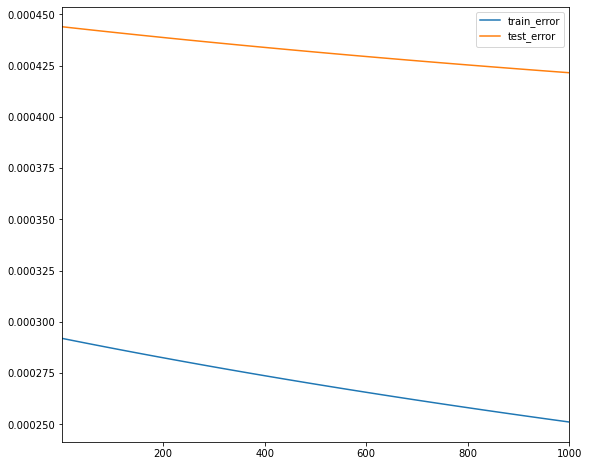

In [128]:
# Solution
model_lowinit = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
artist_neighbors(model_lowinit, "Johnny Cash", DOT)
artist_neighbors(model_lowinit, "Johnny Cash", COSINE)
#movie_embedding_norm([model, model_lowinit])

## 4) Regularization In Matrix Factorization

In our code, loss was defined as the mean squared error on the observed part of the rating matrix.  This can often cause issues when the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We add some regularization terms to deal with this problem:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

Total loss can now be calculated as:
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

In [129]:

def gravity(U, V):
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userId": U, "artistID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

We build the regularised model and observe the results

 iteration 2000: train_error_observed=0.000122, test_error_observed=0.000057, observed_loss=0.000122, regularization_loss=0.003525, gravity_loss=0.000000

[{'train_error_observed': 0.00012176202, 'test_error_observed': 5.6812038e-05},
 {'observed_loss': 0.00012176202,
  'regularization_loss': 0.0035254618,
  'gravity_loss': 2.795214e-08}]

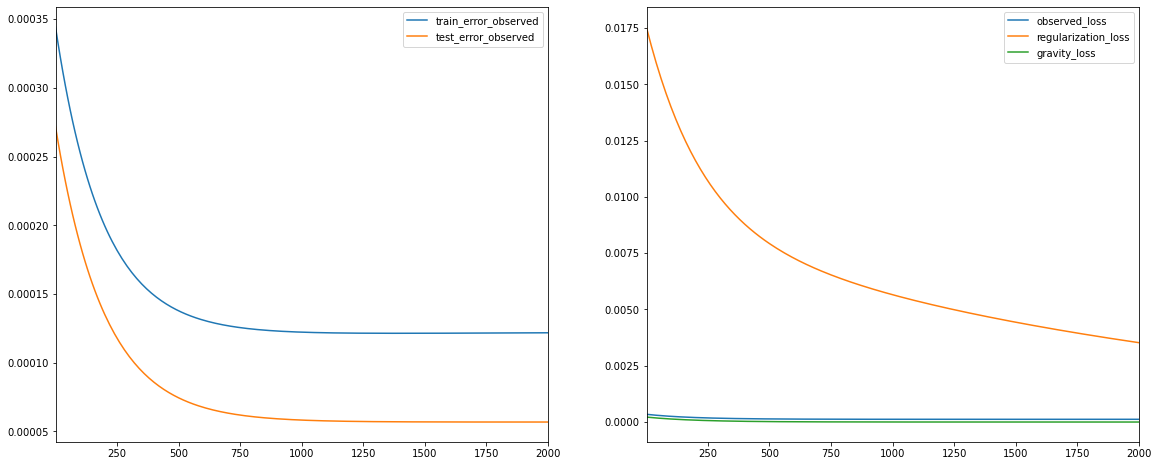

In [130]:
reg_model = build_regularized_model(
    user_artists_norm, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

### Testing

In [131]:
artist_neighbors(model_lowinit, "Queen", DOT)
artist_neighbors(model_lowinit, "Queen", COSINE)

Nearest neighbors of : Queens of the Stone Age.
[Found more than one matching artist. Other candidates: Queensberry, I Killed the Prom Queen, Queen, The Good, the Bad & the Queen, Queensrÿche, Ivy Queen, Fall to the Queen, Queen of the damned ost, Queen + Paul Rodgers, Queen Latifah, Frankenstein Drag Queens From Planet 13, Queen Ifrica]


,dot score,names
220,0.086915,Queens of the Stone Age
14710,0.058737,Wire Daisies
17091,0.057745,Life's Decay
6586,0.052215,Mark Lanegan
15723,0.051566,Animosity
11245,0.051559,Yat-Kha


Nearest neighbors of : Queens of the Stone Age.
[Found more than one matching artist. Other candidates: Queensberry, I Killed the Prom Queen, Queen, The Good, the Bad & the Queen, Queensrÿche, Ivy Queen, Fall to the Queen, Queen of the damned ost, Queen + Paul Rodgers, Queen Latifah, Frankenstein Drag Queens From Planet 13, Queen Ifrica]


,cosine score,names
220,1.000000,Queens of the Stone Age
6373,0.671320,Валерий Леонтьев
13674,0.622286,Gary Go
6586,0.616706,Mark Lanegan
4290,0.614134,Ruth Ruth
5829,0.594732,Tiffany Giardina


## Results

Our recommender system is fully functional and outputs similar artists to whatever artist the user enters. The system appears to have some issues as there are often useful recommendations alongside other, not so useful recommendations. The inner workings of the systems need some work before this would be deemed acceptable however as a starting point it is a useful recommender system to be further fine tuned.